In [16]:
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
from szar.counts import ClusterCosmology
from szar.szproperties import SZ_Cluster_Model
from szar.foregrounds import fgNoises, f_nu
from szar.ilc import ILC_simple, ILC_simple_pol, Filters
import sys,os
from configparser import SafeConfigParser
import pickle as pickle
from orphics.io import dict_from_section, list_from_config, Plotter
from orphics.cosmology import noise_func


home = "/Users/nab/Repos/SZ_filter/"
homeout = "/Users/nab/Repos/SZ_filter/test_output/"

iniFile = home+"/input/pipeline.ini"
Config = SafeConfigParser()
Config.optionxform=str
Config.read(iniFile)

constDict = dict_from_section(Config,'constants')
clusterDict = dict_from_section(Config,'cluster_params')
fparams = {}   # the                                                                                                                 
for (key, val) in Config.items('params'):
    if ',' in val:
        param, step = val.split(',')
        fparams[key] = float(param)
    else:
        fparams[key] = float(val)
        
cc = ClusterCosmology(fparams,constDict,lmax=8000,pickling=True)#clTTFixFile=clttfile)                                               

fgs = fgNoises(cc.c,ksz_file=home+"input/ksz_BBPS.txt",ksz_p_file=home+"input/ksz_p_BBPS.txt",\
               tsz_cib_file=home+"input/sz_x_cib_template.dat",\
               tsz_battaglia_template_csv=home+"data/sz_template_battaglia.csv")
thk = 2.5

Populating the interactive namespace from numpy and matplotlib
Generating theory Cls...

`%matplotlib` prevents importing * from pylab and numpy
/Users/nab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
/Users/nab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.



Loaded cached Cls from  output/clsAll_low_acc_False_8000_20180608.pkl
Loaded cached Cls from  output/clphi_low_acc_False_8000_20180608.txt


In [19]:
experimentName = "SO-v2-6m"
#experimentName = "CCATP-SO-MSIP"                                                                                                         
beams = list_from_config(Config,experimentName,'beams')
noises = list_from_config(Config,experimentName,'noises')
freqs = list_from_config(Config,experimentName,'freqs')
lmax = int(Config.getfloat(experimentName,'lmax'))
lknee = list_from_config(Config,experimentName,'lknee')[0]
alpha = list_from_config(Config,experimentName,'alpha')[0]
fsky = Config.getfloat(experimentName,'fsky')

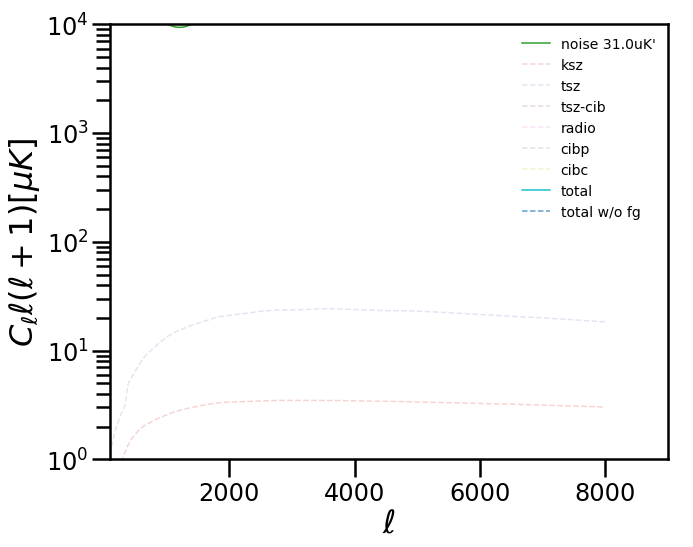

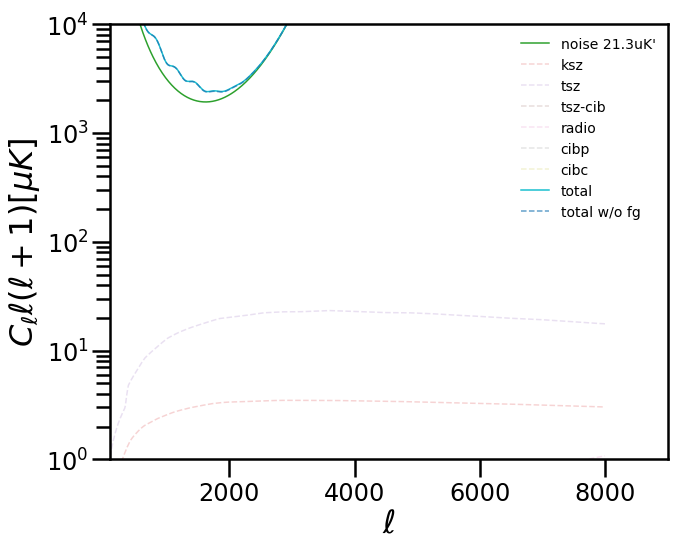

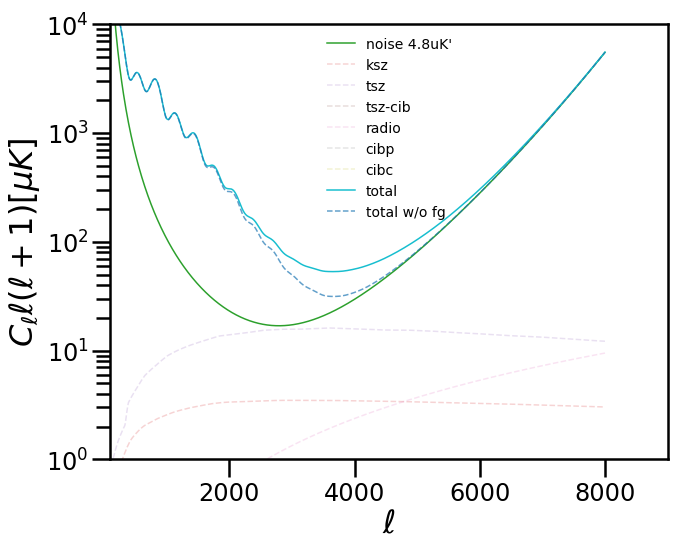

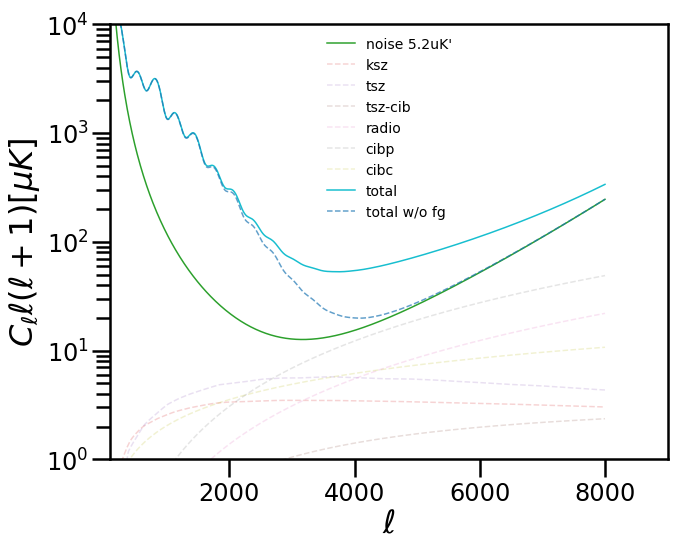

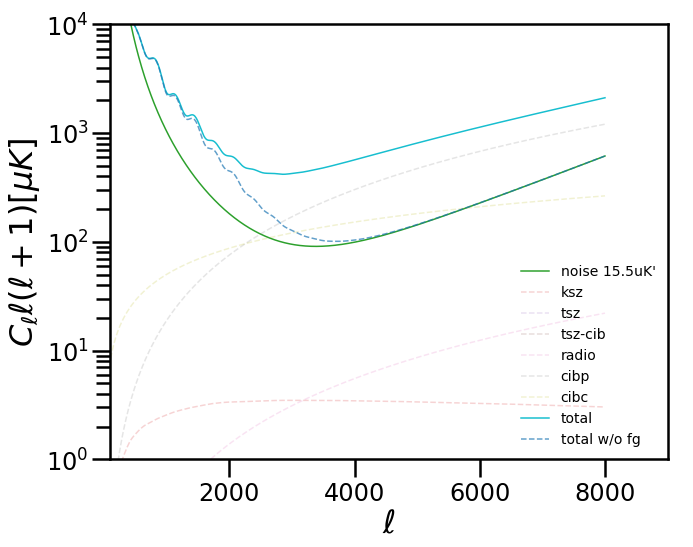

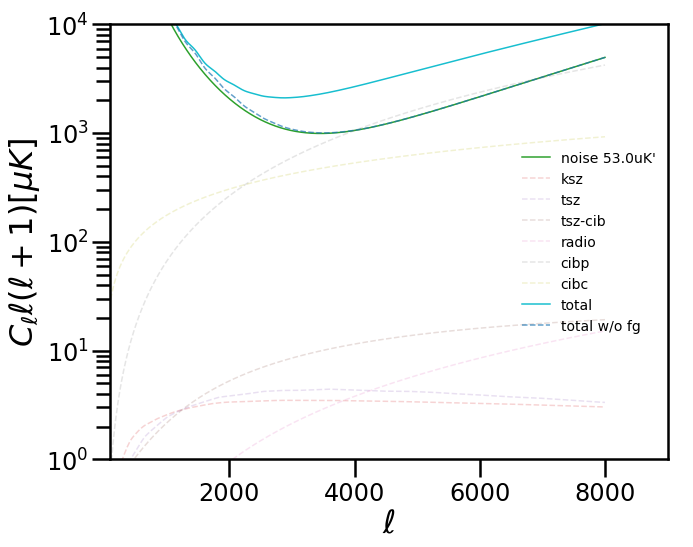

In [20]:
ls = np.arange(2,8000,10)
yrang = [1,10000]
xrang = [100.,9000.]
fac_norm = ls*(ls+1.)/(2.*np.pi) * cc.c['TCMBmuK']**2

for fwhm,noiseT,testFreq in zip(beams,noises,freqs):
    totCl = 0.                                                                                                                            
    noise = noise_func(ls,fwhm,noiseT,lknee,alpha,dimensionless=False) / cc.c['TCMBmuK']**2.

    radio = fgs.rad_ps(ls,testFreq,testFreq)/ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.
    cibp = fgs.cib_p(ls,testFreq,testFreq) /ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.
    cibc = fgs.cib_c(ls,testFreq,testFreq)/ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.
    tsz = fgs.tSZ(ls,testFreq,testFreq)/ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.
    tsz_cib = np.abs(fgs.tSZ_CIB(ls,testFreq,testFreq)/ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.)
    ksz = fgs.ksz_temp(ls)/ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.
    
    pol_dust = fgs.gal_dust_pol(ls,testFreq,testFreq) /ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.
    pol_ps   = fgs.rad_pol_ps(ls,testFreq,testFreq) /ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.
    pol_sync = fgs.gal_sync_pol(ls,testFreq,testFreq) /ls/(ls+1.)*2.*np.pi/ cc.c['TCMBmuK']**2.

    totCl = cc.theory.lCl('TT',ls)+ksz+radio+cibp+cibc+noise+tsz+tsz_cib
    oldtotCl = cc.theory.lCl('TT',ls)+noise

    fig = plt.figure(figsize=(10,8))
    rc('axes', linewidth=thk)
    plt.tick_params(which='both',size=14,width=thk,labelsize = 24)
    plt.tick_params(which='major',size=18,width=thk,labelsize = 24)
    plt.xlabel(r'$\ell$', fontsize=32,weight='bold')
    plt.ylabel(r'$C_\ell \ell (\ell + 1) [\mu K]$', fontsize=32,weight='bold')
    plt.xlim(xrang)
    plt.ylim(yrang)
    plt.semilogy(ls,cc.theory.uCl('TT',ls)*ls**2.,alpha=0.3,ls="--")
    plt.plot(ls,cc.theory.lCl('TT',ls)*ls**2.)
    plt.plot(ls,noise*fac_norm,label="noise "+str(noiseT)+"uK'")
    plt.plot(ls,ksz*fac_norm,label="ksz",alpha=0.2,ls="--")
    plt.plot(ls,tsz*fac_norm,label="tsz",alpha=0.2,ls="--")
    plt.plot(ls,tsz_cib*fac_norm,label="tsz-cib",alpha=0.2,ls="--")
    # pl.add(ls,kszAlt*ls**2.,label="ksz",alpha=0.5,ls="--")                                                                                   
    plt.plot(ls,radio*fac_norm,label="radio",alpha=0.2,ls="--")
    plt.plot(ls,cibp*fac_norm,label="cibp",alpha=0.2,ls="--")
    plt.plot(ls,cibc*fac_norm,label="cibc",alpha=0.2,ls="--")
    plt.plot(ls,totCl*fac_norm,label="total")
    plt.plot(ls,oldtotCl*fac_norm,label="total w/o fg",alpha=0.7,ls="--")
    
    leg = legend(loc=0,numpoints=1,prop={"size":14})
    leg.draw_frame(False)
    plt.savefig(homeout+'test_fgs_nu'+str(freqs)+'GHz.png', bbox_inches='tight',format='png')